In [1]:
# author: Jana Lasser

In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import krippendorff
import pingouin as pt
from scipy.stats import pearsonr, skew

In [61]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

# New York Times corpus

**Note**: the below code won't work if you haven't collected the NYT articles corpus yourself, since we can't share the data.

In [70]:
src = "../../data/NYT/"
fname = "abstracts.csv.gzip"
abstracts = pd.read_csv(Path(src, fname), compression="gzip")


# merge categories
abstracts["section"] = abstracts["section"].replace({
    "Climate":"Science",
    "Education":"Science",
    "Health":"Science",
    "U.S.":"Politics",
    "Washington":"Politics",
    "World":"Politics"
})
abstracts.head(3)

,section,avg_belief_score,avg_truth_score
0,Politics,0.619713,0.536311
1,Politics,0.618543,0.642781
2,Opinion,0.776838,0.662415


In [71]:
# calculate corpus means for belief-speaking and truth-seeking similarity
belief_corpus_mean = abstracts["avg_belief_score"].mean()
truth_corpus_mean = abstracts["avg_truth_score"].mean()

In [72]:
abstracts[["section", "avg_belief_score"]].groupby("section").mean() - belief_corpus_mean

,avg_belief_score
section,
Opinion,0.012694
Politics,-0.006802
Science,0.009306


In [73]:
abstracts[["section", "avg_truth_score"]].groupby("section").mean() - truth_corpus_mean

,avg_truth_score
section,
Opinion,0.006216
Politics,-0.006138
Science,0.033311


# Users

In [36]:
src = "../../data/users"
fname = "users.csv"
users = pd.read_csv(Path(src, fname), dtype={"author_id":str})
users.head(3)

,handle,author_id,name,party,N_tweets,followers_count,following_count,tweet_count,created_at,congress,...,LIWC_moral_mean,VADER_neg_mean,VADER_pos_mean,VADER_neu_mean,VADER_compound_mean,ideology_mean,ideology_std,ideology_count,state,pf_score
0,RepCori,1002630999052865536,Congresswoman Cori Bush,Democrat,1471,116684,297,1866,2018-06-01 19:20:32+00:00,118.0,...,0.982597,0.082815,0.136428,0.780762,0.165968,0.102091,NaN,1.0,MO,NaN
1,RepFitzgerald,1004891731,Rep. Scott Fitzgerald,Republican,2043,11409,820,2936,2012-12-11 21:01:37+00:00,118.0,...,0.384058,0.043388,0.142050,0.814558,0.238641,0.553606,NaN,1.0,WI,NaN
2,RepLipinski,1009269193,Former Rep. Daniel Lipinski,Democrat,3524,19355,2459,4350,2012-12-13 17:03:06+00:00,116.0,...,0.604069,0.044630,0.162399,0.792972,0.366742,0.471657,0.055874,8.0,IL,NaN


In [37]:
dem = users[users["party"] == "Democrat"].copy()
rep = users[users["party"] == "Republican"].copy()

In [38]:
len(users)

1058

## Number of Democrats and Republicans in both time periods

In [39]:
len(dem["avg_belief_score_2010_to_2013"].dropna())

331

In [40]:
len(dem["avg_belief_score_2019_to_2022"].dropna())

514

In [41]:
len(rep["avg_belief_score_2010_to_2013"].dropna())

295

In [42]:
len(rep["avg_belief_score_2019_to_2022"].dropna())

494

## Mean values of belief-speaking and truth-seeking similarity

In [43]:
dem["avg_belief_score_2010_to_2013"].mean()

-0.031087137956548154

In [44]:
dem["avg_belief_score_2019_to_2022"].mean()

0.01679975176056016

In [45]:
rep["avg_belief_score_2010_to_2013"].mean()

-0.04022899954666405

In [46]:
rep["avg_belief_score_2019_to_2022"].mean()

0.011538102344141737

In [47]:
dem["avg_truth_score_2010_to_2013"].mean()

-0.0272451628838662

In [48]:
dem["avg_truth_score_2019_to_2022"].mean()

0.009172628333680271

In [49]:
rep["avg_truth_score_2010_to_2013"].mean()

-0.037706695563842776

In [50]:
rep["avg_truth_score_2019_to_2022"].mean()

-0.00260137451585453

## T-tests to compare differences

In [51]:
# Democrats belief-speaking
pt.ttest(dem["avg_belief_score_2010_to_2013"],
         dem["avg_belief_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-11.31741,558.354272,two-sided,7.074804e-27,"[-0.06, -0.04]",0.850142,2.948e+24,1.0


In [52]:
# Republicans belief-speaking
pt.ttest(rep["avg_belief_score_2010_to_2013"],
         rep["avg_belief_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-10.819444,492.989126,two-sided,1.266421e-24,"[-0.06, -0.04]",0.853795,1.968e+22,1.0


In [53]:
# Democrats truth-seeking
pt.ttest(dem["avg_truth_score_2010_to_2013"],
         dem["avg_truth_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-9.752772,515.959467,two-sided,9.741910e-21,"[-0.04, -0.03]",0.748282,1.61e+18,1.0


In [54]:
# Republicans truth-seeking
pt.ttest(rep["avg_truth_score_2010_to_2013"],
         rep["avg_truth_score_2019_to_2022"], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.442057,482.836161,two-sided,3.668184e-16,"[-0.04, -0.03]",0.670516,3.207e+13,1.0


## Users that contribute the most to changing honesty components

In [55]:
dem["avg_belief_score_difference"] = dem["avg_belief_score_2019_to_2022"] / \
                                     dem["avg_belief_score_2010_to_2013"] * 100 
dem["avg_truth_score_difference"] = dem["avg_truth_score_2019_to_2022"] / \
                                     dem["avg_truth_score_2010_to_2013"] * 100
rep["avg_belief_score_difference"] = rep["avg_belief_score_2019_to_2022"] / \
                                     rep["avg_belief_score_2010_to_2013"] * 100
rep["avg_truth_score_difference"] = rep["avg_truth_score_2019_to_2022"] / \
                                     rep["avg_truth_score_2010_to_2013"] * 100

In [56]:
dem["avg_belief_score_difference_raw"] = dem["avg_belief_score_2019_to_2022"] -\
                                     dem["avg_belief_score_2010_to_2013"] 
dem["avg_truth_score_difference_raw"] = dem["avg_truth_score_2019_to_2022"] -\
                                     dem["avg_truth_score_2010_to_2013"] 
rep["avg_belief_score_difference_raw"] = rep["avg_belief_score_2019_to_2022"] -\
                                     rep["avg_belief_score_2010_to_2013"] 
rep["avg_truth_score_difference_raw"] = rep["avg_truth_score_2019_to_2022"] -\
                                     rep["avg_truth_score_2010_to_2013"]

### Belief-speaking

In [57]:
dem = dem.sort_values(by=["avg_belief_score_difference_raw"], ascending=False)
rep = rep.sort_values(by=["avg_belief_score_difference_raw"], ascending=False)
cols = ["handle", "avg_belief_score_difference_raw", "N_tweets", "avg_belief_score_2010_to_2013", "avg_belief_score_2019_to_2022"]

In [58]:
dem[cols][0:10]

,handle,avg_belief_score_difference_raw,N_tweets,avg_belief_score_2010_to_2013,avg_belief_score_2019_to_2022
406,SenatorLujan,0.439350,5369,-0.427124,0.012226
905,SenStabenow,0.363813,6279,-0.325639,0.038174
446,SenBooker,0.281887,5088,-0.244836,0.037052
764,aguilarpete,0.216339,541,-0.011172,0.205167
1034,WilliamKeating,0.209026,713,-0.174870,0.034156
480,USRepKeating,0.199555,2162,-0.157711,0.041844
203,pallonefornj,0.193862,2182,-0.141561,0.052301
677,BobbyScott4VA3,0.176313,1163,-0.275243,-0.098930
31,TulsiPress,0.174907,4004,-0.147119,0.027788
360,Matsui4Congress,0.171611,843,-0.157768,0.013843


In [59]:
rep[cols][0:10]

,handle,avg_belief_score_difference_raw,N_tweets,avg_belief_score_2010_to_2013,avg_belief_score_2019_to_2022
886,SenBobCorker,0.307040,3800,-0.144048,0.162992
616,GrassleyPress,0.287462,9386,-0.284752,0.002710
892,McCaulforTexas,0.264878,3138,-0.248697,0.016181
405,krhern,0.237205,679,-0.147185,0.090020
929,votetimscott,0.209389,2563,-0.118062,0.091327
748,MaElviraSalazar,0.197998,4829,-0.508628,-0.310630
548,congbillposey,0.193501,650,-0.313193,-0.119691
724,MacTXPress,0.189567,556,-0.118393,0.071174
157,MikeKellyforPA,0.187672,277,-0.126396,0.061276
571,JohnKennedyLA,0.186556,651,-0.119126,0.067431


### Truth-seeking

In [278]:
dem = dem.sort_values(by=["avg_truth_score_difference_raw"], ascending=False)
rep = rep.sort_values(by=["avg_truth_score_difference_raw"], ascending=False)
cols = ["handle", "avg_truth_score_difference_raw", "N_tweets", "avg_truth_score_2010_to_2013", "avg_truth_score_2019_to_2022"]

In [279]:
dem[cols][0:10]

,handle,avg_truth_score_difference_raw,N_tweets,avg_truth_score_2010_to_2013,avg_truth_score_2019_to_2022
406,SenatorLujan,0.345976,5369,-0.327637,0.018339
905,SenStabenow,0.294308,6279,-0.253833,0.040475
1034,WilliamKeating,0.197950,713,-0.188990,0.008960
31,TulsiPress,0.193489,4004,-0.139192,0.054297
1031,DeGette5280,0.182647,1195,-0.152255,0.030392
480,USRepKeating,0.177597,2162,-0.136001,0.041597
360,Matsui4Congress,0.158593,843,-0.177410,-0.018816
446,SenBooker,0.156449,5088,-0.117531,0.038917
691,RepJoseSerrano,0.154026,4168,-0.213723,-0.059696
677,BobbyScott4VA3,0.147754,1163,-0.254986,-0.107232


In [280]:
rep[cols][0:10]

,handle,avg_truth_score_difference_raw,N_tweets,avg_truth_score_2010_to_2013,avg_truth_score_2019_to_2022
892,McCaulforTexas,0.255068,3138,-0.251097,0.003971
886,SenBobCorker,0.229819,3800,-0.114537,0.115282
616,GrassleyPress,0.213713,9386,-0.173018,0.040695
214,TeamCMR,0.194999,1024,-0.140974,0.054024
548,congbillposey,0.188606,650,-0.253476,-0.064869
565,cindyhydesmith,0.163499,1898,-0.137314,0.026185
679,stephaniebice,0.160735,3001,-0.153735,0.006999
929,votetimscott,0.158586,2563,-0.126239,0.032347
562,CurtisUT,0.155091,3663,-0.128574,0.026517
157,MikeKellyforPA,0.154914,277,-0.152242,0.002672


## How much do politicians tweet?

In [283]:
users["N_tweets"].median()

2876.0

In [6]:
users["N_tweets"].mean()

4279.5973534971645

In [74]:
users["N_tweets"].quantile(0.75)

5784.5

In [75]:
users["N_tweets"].quantile(0.9)

9799.2

In [76]:
users["N_tweets"].max()

52055

In [77]:
users.loc[users["N_tweets"].idxmax()]

handle                                          CoryBooker
author_id                                         15808765
name                                           Cory Booker
party                                             Democrat
N_tweets                                             52055
followers_count                                    4835121
following_count                                      85100
tweet_count                                          67749
created_at                       2008-08-11 14:41:16+00:00
congress                                             117.0
type                                              official
NG_unreliable_share                               0.011882
NG_score_mean                                    93.538774
accuracy_mean                                     3.864181
transparency_mean                                  2.77763
independent_unreliable_share                      0.019973
avg_belief_score                                  0.5435

(array([480., 246., 163.,  68.,  41.,  29.,  12.,   9.,   3.,   3.,   1.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0,  2500,  5000,  7500, 10000, 12500, 15000, 17500, 20000,
        22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500,
        45000, 47500, 50000, 52500]),
 <BarContainer object of 21 artists>)

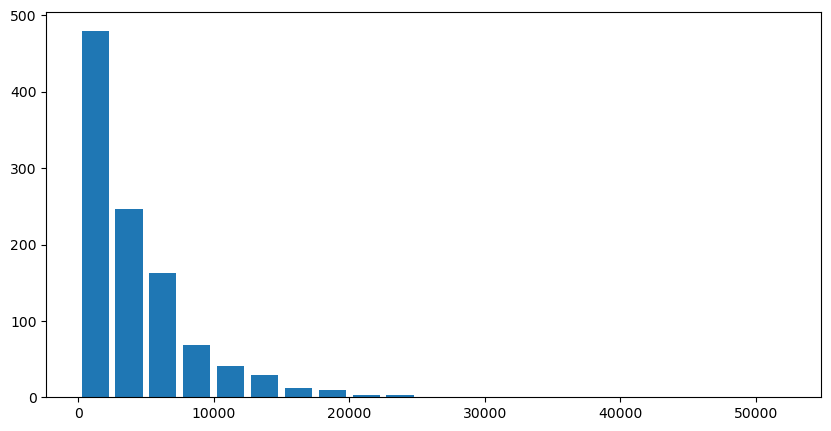

In [78]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(users["N_tweets"], bins=range(0, 55000, 2500), rwidth=0.8)

In [79]:
skew(users["N_tweets"])

2.8392189876401766

# Tweets

## Number of tweets

In [31]:
src = "../../data/tweets"
fname = "tweets.csv.gzip"
tweets = pd.read_csv(
    Path(src, fname),
    compression="gzip", 
    parse_dates=["created_at"]
)

In [4]:
print(f"number of tweets in the corpus: {len(tweets)}")
print("number of original in the corpus: {}"\
      .format(len(tweets[(tweets["retweeted"] == False) &\
                         (tweets["quoted"] == False) &\
                         (tweets["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(tweets[tweets["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(tweets[tweets["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(tweets[tweets["retweeted"] == True])))

number of tweets in the corpus: 4562761
number of original in the corpus: 3463409
number of quoted tweets in the corpus: 531289
number of replies in the corpus: 575044
number of retweets in the corpus: 0


In [5]:
tweets["year"] = pd.to_datetime(tweets["created_at"]).dt.year

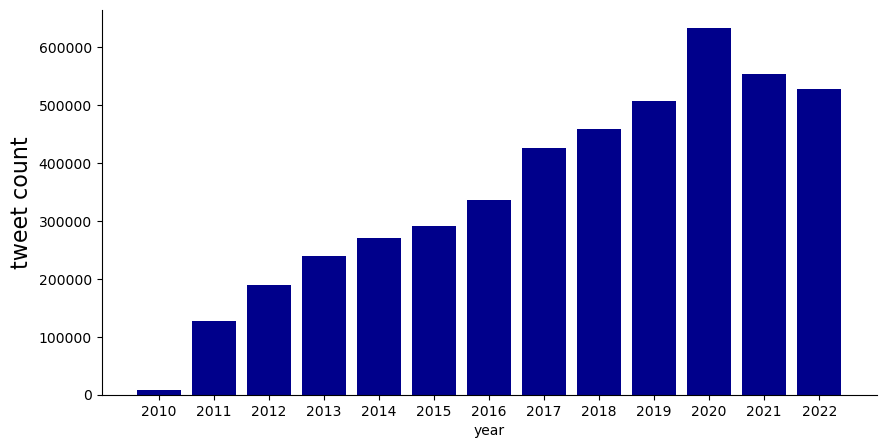

In [6]:
counts, years = np.histogram(tweets["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(tweets["year"].value_counts(ascending=True).index,
       tweets["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2023))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [7]:
# drop tweets without honesty component (distill RoBERTa filtering)
N = len(tweets)
tweets = tweets.dropna(subset=["avg_belief_score", "avg_truth_score"])
print(f"dropped {N - len(tweets)} tweets without an honesty score")

dropped 633096 tweets without an honesty score


In [8]:
# set tweet creation date as index for easier sampling and aggregation
tweets = tweets.set_index("created_at")

In [9]:
print(f"N tweets in final corpus {len(tweets)}")

N tweets in final corpus 3929665


In [10]:
tweets["has_url"].sum()

2722467

## Score correlations

In [11]:
tweets["avg_belief_score"].mean()

0.0030045229285424998

In [12]:
tweets["avg_truth_score"].mean()

0.002068118062444128

In [13]:
subset = tweets[["avg_belief_score", "LIWC_analytic"]].dropna()
pearsonr(subset["avg_belief_score"], subset["LIWC_analytic"])

(-0.2722021992367906, 0.0)

In [14]:
subset = tweets[["avg_truth_score", "LIWC_analytic"]].dropna()
pearsonr(subset["avg_truth_score"], subset["LIWC_analytic"])

(-0.16494125351876623, 0.0)

In [15]:
subset = tweets[["avg_belief_score", "LIWC_authentic"]].dropna()
pearsonr(subset["avg_belief_score"], subset["LIWC_authentic"])

(0.09684722618887409, 0.0)

In [16]:
subset = tweets[["avg_truth_score", "LIWC_authentic"]].dropna()
pearsonr(subset["avg_truth_score"], subset["LIWC_authentic"])

(0.057858474847408345, 0.0)

In [17]:
subset = tweets[["avg_belief_score", "LIWC_moral"]].dropna()
pearsonr(subset["avg_belief_score"], subset["LIWC_moral"])

(0.07060771341432126, 0.0)

In [18]:
subset = tweets[["avg_truth_score", "LIWC_moral"]].dropna()
pearsonr(subset["avg_truth_score"], subset["LIWC_moral"])

(0.01686111180199903, 5.596941525803395e-245)

In [19]:
subset = tweets[["avg_belief_score", "VADER_pos"]].dropna()
pearsonr(subset["avg_belief_score"], subset["VADER_pos"])

(0.055787087292489296, 0.0)

In [20]:
subset = tweets[["avg_truth_score", "VADER_pos"]].dropna()
pearsonr(subset["avg_truth_score"], subset["VADER_pos"])

(-0.005529639470196597, 5.839447977768097e-28)

In [21]:
subset = tweets[["avg_belief_score", "VADER_neg"]].dropna()
pearsonr(subset["avg_belief_score"], subset["VADER_neg"])

(0.18865061802404093, 0.0)

In [22]:
subset = tweets[["avg_truth_score", "VADER_neg"]].dropna()
pearsonr(subset["avg_truth_score"], subset["VADER_neg"])

(0.15225216981580697, 0.0)

## Tweets that are high on both honesty components

In [32]:
top_truth = tweets["avg_truth_score"].quantile(0.66)
bottom_belief = tweets["avg_belief_score"].quantile(0.33)

In [33]:
selection = tweets[(tweets["avg_truth_score"] > top_truth) & \
                   (tweets["avg_belief_score"] < bottom_belief)& \
                   (tweets["NG_score"] < 60)]

In [34]:
len(selection)

26

In [35]:
del tweets

# Articles

In [8]:
src = "../../data/articles"

In [9]:
fname = "url_list_for_article_scraping.csv.gzip"
url_list = pd.read_csv(
    Path(src, fname), 
    compression="gzip"
)

In [10]:
unwanted_domains = ["twitter.com", "facebook.com", "youtube.com", "instagram.com", "google.com", "yahoo.com"]
url_list = url_list[~url_list["domain"].isin(unwanted_domains)]
url_list = url_list.drop_duplicates(subset=["url"])

In [11]:
len(url_list)

1027050

In [12]:
fname = "url_NG_scores.csv.gzip"
article_NG_scores = pd.read_csv(
    Path(src, fname),
    compression="gzip"
)
article_NG_scores = article_NG_scores.dropna()
article_NG_scores = article_NG_scores.drop_duplicates(subset=["party", "url"])

In [13]:
fname = "article_corpus_clean.csv.gzip"
articles = pd.read_csv(Path(src, fname), compression="gzip")
articles = articles.drop_duplicates(subset=["url", "party"])
len(articles)

354335

In [14]:
article_NG_scores_clean = pd.merge(
    article_NG_scores,
    articles[["url", "link_text"]],
    how="left",
    left_on="url",
    right_on="url"
)

In [15]:
article_NG_scores_clean = article_NG_scores_clean.drop_duplicates(subset=["url", "party"])

In [16]:
len(article_NG_scores_clean["url"].unique())

462853

In [17]:
article_NG_scores_clean = article_NG_scores_clean[article_NG_scores_clean["party"].isin(["Democrat", "Republican"])]

In [18]:
N_articles = len(article_NG_scores_clean["url"].unique())
N_collected = len(article_NG_scores_clean.dropna(subset=["link_text"])["url"].unique())

N_articles_low = len(article_NG_scores_clean[article_NG_scores_clean["NG_score"] < 60]["url"].unique())
N_articles_high = len(article_NG_scores_clean[article_NG_scores_clean["NG_score"] >= 60]["url"].unique())

N_collected_low = len(article_NG_scores_clean[article_NG_scores_clean["NG_score"] < 60].dropna(subset=["link_text"])["url"].unique())
N_collected_high = len(article_NG_scores_clean[article_NG_scores_clean["NG_score"] >= 60].dropna(subset=["link_text"])["url"].unique())
                        
print(f"overall collected: {(N_collected / N_articles) * 100:1.2f}% ({N_collected}/{N_articles})")
print(f"low NG score collected: {(N_collected_low / N_articles_low) * 100:1.2f}% ({N_collected_low}/{N_articles_low})")
print(f"high NG score collected: {(N_collected_high / N_articles_high) * 100:1.2f}% ({N_collected_high}/{N_articles_high})")

overall collected: 65.01% (298919/459808)
low NG score collected: 81.82% (7776/9504)
high NG score collected: 64.65% (291143/450304)


In [19]:
party_counts = article_NG_scores_clean[["url", "party"]]\
    .groupby("url")\
    .count()\
    .reset_index()\
    .rename(columns={"party":"party_count"})

In [20]:
article_NG_scores_clean = pd.merge(
    article_NG_scores_clean,
    party_counts,
    how="left",
    left_on="url",
    right_on="url"
)
article_NG_scores_clean = article_NG_scores_clean.drop_duplicates(subset=["url"])

In [27]:
article_NG_scores_clean = article_NG_scores_clean.drop_duplicates(subset=["link_text"])

In [28]:
article_NG_scores_clean["party_count"].value_counts()

1    271171
2      2462
Name: party_count, dtype: int64

In [29]:
(2462 / 271171) * 100

0.9079141943644417

# Trustworthiness scores

## NewsGuard nutrition scores

In [38]:
# load the nutrition labels
src = "../../data/utilities"
fname = "NewsGuard_labels.csv"
NG_scores = pd.read_csv(Path(src, fname))
# if more than one score exists for the same domain, keep the most recent one
NG_scores = NG_scores.sort_values(by=["Domain","Last Updated"], ascending=False)
NG_scores = NG_scores.drop_duplicates(subset=["Domain"])

# threshold scores at various cutoffs to define untrustworthy domains
NG_scores["NewsGuard_unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "NewsGuard_unreliable"] = 1
unreliable_60_domains = set(NG_scores[NG_scores["NewsGuard_unreliable"] == 1]["Domain"])

In [39]:
number_of_english_domains = NG_scores["Language"].value_counts().loc["en"]

unreliable_60 = len(NG_scores[(NG_scores["Language"] == "en") &\
                        (NG_scores["Score"] < 60)]) / \
                        len(NG_scores[NG_scores["Language"] == "en"])

print("The NewsGuard dataset as of 2022-03-01 contains {} english entries"\
        .format(number_of_english_domains))
print("{:1.2f} % ({}) of English entries have a score < 60"\
        .format(unreliable_60 * 100, len(unreliable_60_domains)))

The NewsGuard dataset as of 2022-03-01 contains 6860 english entries
37.24 % (2757) of English entries have a score < 60


Text(15, 2000, 'not trustworthy')

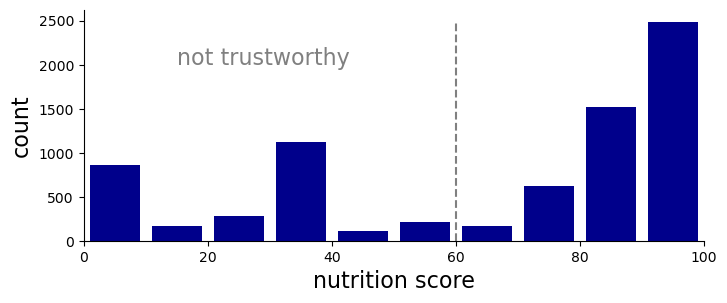

In [40]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.hist(NG_scores["Score"], rwidth=0.8, color="DarkBlue")
ax.set_xlim(0, 100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("count", fontsize=16)
ax.set_xlabel("nutrition score", fontsize=16)
ax.plot([60, 60], [0, 2500], '--', color="grey")
ax.text(15, 2000, "not trustworthy", color="grey", fontsize=16)

## Independent trustworthiness labels

In [41]:
# load the list of independently compiled trustworthiness labels for 
# news sources
src = "../../data/utilities"
fname = "independent_labels.csv"
alt_labels = pd.read_csv(Path(src, fname))
alt_labels = alt_labels.rename(columns = {"type":"unreliable", "url":"Domain"})

# convert reliability labels to binary
alt_labels["unreliable"] = alt_labels["unreliable"]\
    .replace({"reliable":0, "unreliable":1})
N_alt_labels = len(alt_labels)
N_alt_untrustworthy = alt_labels["unreliable"].value_counts().loc[1]

In [42]:
NG_domains = set(NG_scores["Domain"])
alt_domains = set(alt_labels["Domain"])
shared_domains = len(NG_domains.intersection(alt_domains))
untrustworthy_domains = set(alt_labels[alt_labels["unreliable"] == 1]["Domain"])
shared_untrustworthy_domains_60 = len(unreliable_60_domains\
                                   .intersection(untrustworthy_domains))

In [43]:
print(f"The alternative list contains {N_alt_labels} domains")
print(f"Out of which {N_alt_untrustworthy} are labelled 'untrustworthy'")
print(f"{shared_domains} domains are also indexed by NewsGuard")
print(f"{shared_untrustworthy_domains_60} untrustworthy domains are also indexed by NewsGuard (score < 60)")

The alternative list contains 4767 domains
Out of which 2170 are labelled 'untrustworthy'
1677 domains are also indexed by NewsGuard
566 untrustworthy domains are also indexed by NewsGuard (score < 60)


## Comparison NewsGuard <-> independent labels

In [44]:
alt_domains = set(alt_labels["Domain"])

In [45]:
len(alt_domains)

4767

In [111]:
alt_labels["unreliable"].value_counts()

0    2597
1    2170
Name: unreliable, dtype: int64

In [112]:
NG_domains = set(NG_scores["Domain"])

In [113]:
in_both = alt_domains.intersection(NG_domains)
len(in_both)

1677

In [114]:
alt_labels[alt_labels["Domain"].isin(list(NG_domains))]["unreliable"].value_counts()

0    1062
1     615
Name: unreliable, dtype: int64

In [115]:
alt_labels["unreliable"] = alt_labels["unreliable"].replace({
    "reliable":0,
    "unreliable":1
})

In [116]:
NG_scores["unreliable"] = 0
NG_scores.loc[NG_scores[NG_scores["Score"] < 60].index, "unreliable"] = 1

In [117]:
labels_NG = NG_scores[NG_scores["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
labels_ind = alt_labels[alt_labels["Domain"].isin(in_both)]\
    .sort_values(by="Domain")[["Domain", "unreliable"]]
joint_labels = pd.DataFrame({
    "label_NG":labels_NG["unreliable"].values,
    "label_ind":labels_ind["unreliable"].values})

same = len(joint_labels[joint_labels["label_NG"] == joint_labels["label_ind"]])
kripp = krippendorff.alpha(joint_labels.transpose())
print(f"number of same labels: {same}, krippendorff's alpha: {kripp}")

number of same labels: 1553, krippendorff's alpha: 0.8422170341180256
